In [2]:
import os
import h5py
import json

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd

import gizmo_analysis as ga


%matplotlib inline

mpl.rc('figure', figsize=(8, 5), facecolor='w')
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 16
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

### From Gizmo

In [3]:
# Picking a sample simulation and a snapshot. 
sim_dir = f'/scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12i_res7100'
nsnap = 600

#Read using gizmo
part = ga.io.Read.read_snapshots(
    species=['star'], snapshot_values=nsnap, simulation_directory=sim_dir,
    assign_hosts=True, assign_hosts_rotation=True)


# in utilities.simulation.Snapshot():
* reading:  scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12i_res7100/snapshot_times.txt

  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 57060074 particles
    star      (id = 4): 13976485 particles
    blackhole (id = 5): 0 particles

* reading species: ['star']
* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

* reading cosmological parameters from:  scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12i_res7100/initial_condition/ic_agora_m12i.conf

* checking sanity of particle properties


# in gizmo_analysis.gizmo_track.ParticleCoo

In [29]:
pos = part['star'].prop('host.distance.principle')
r = np.sqrt(np.sum(pos**2, 1))

# cut particles too far away from host galaxy
select = r < 20
pos = pos[select]
r = r[select]
x, y, z = pos.T

/work/08317/tg876168/stampede2/anaconda3/envs/fire-torch/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


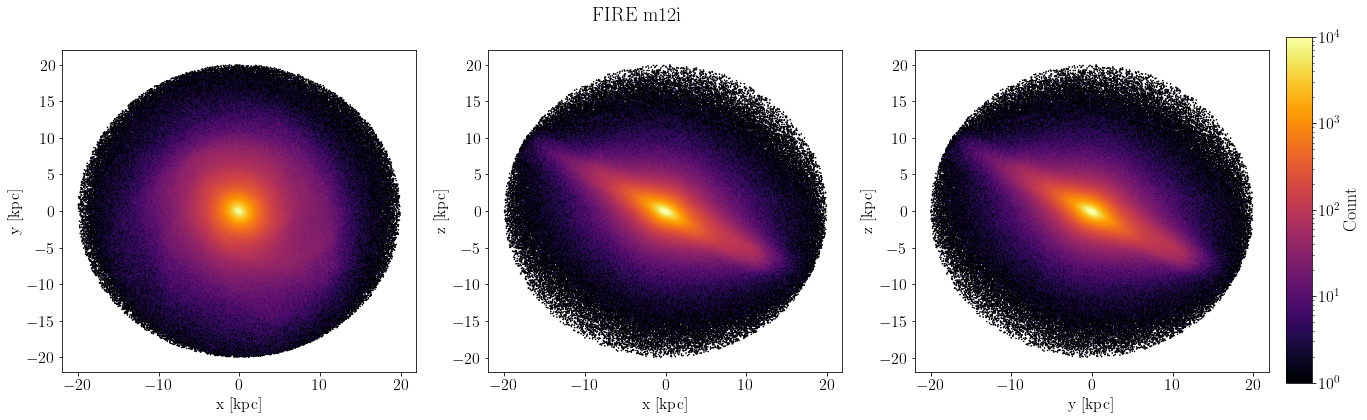

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
ax1, ax2, ax3 = axes.ravel()

gridsize = 500
norm = colors.LogNorm(vmin=1, vmax=1e4)

# plot x-y plane
hb = ax1.hexbin(x, y, gridsize=gridsize, mincnt=1, norm=norm, cmap='inferno')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')

# plot x-z 
ax2.hexbin(x, z, gridsize=gridsize, mincnt=1, norm=norm, cmap='inferno')
ax2.set_xlabel('x [kpc]')
ax2.set_ylabel('z [kpc]')

# plot y-z plane
ax3.hexbin(x, z, gridsize=gridsize, mincnt=1, norm=norm, cmap='inferno')
ax3.set_xlabel('y [kpc]')
ax3.set_ylabel('z [kpc]')

# set colorbars
cbar_ax = fig.add_axes([1.0, 0.11, 0.02, 0.8])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.set_label(r'Count', fontsize=18)

fig.suptitle('FIRE m12i', fontsize=20)
fig.tight_layout()
fig.savefig('m12i_proj_gizmo_test.png', dpi=300, bbox_inches='tight')

### From accretion table

In [33]:
def read_data(table_fn, action_fn=None):
    ''' Read in the properties of accreted stars '''
        
    properties = [
        'id_stars', 'subhalo_mass_stars', 'subhalo_stellar_mass_stars', 
        'subhalo_infall_mass_stars', 'subhalo_infall_stellar_mass_stars', 
        'redshift_stars', 'feH', 'radial_distance_stars', 
        'xstar', 'ystar', 'zstar', 'vxstar', 'vystar', 'vzstar', 
        'r_cyl', 'phi_cyl', 'z_cyl', 'vr_cyl', 'vphi_cyl', 'vz_cyl', 
        'x_cart', 'y_cart', 'z_cart', 'vx_cart', 'vy_cart', 'vz_cart', 

    ]

    # read in the CSV table the accretion history of FIRE particles
    table = pd.read_csv(table_fn)
    data = {}    
    for i, prop in enumerate(properties):
        data[prop] = table[prop].to_numpy()
        
    # read in the action if given
    if action_fn is not None:
        with h5py.File(action_fn, 'r') as f:
            action_id_stars = f['id_stars'][:]
            # sort id
            sort = np.argsort(action_id_stars)
            action_id_stars = action_id_stars[sort]
            Jr = f['Jr'][:][sort] / 1000
            Jz = f['Jz'][:][sort] / 1000
            Jphi = f['Jphi'][:][sort] / 1000
    
    
    # apply some data quality cut
    mask = (data['feH'] > -3.5)  # FeH < -3.5 are close to the FIRE FeH lower bound (-4)
    
    # below 10^9 solar mass, FIRE does not have sufficient mass resolution, 
    # so we want to consider only stars with subhalo mass above 10^9
    mask &= (data['subhalo_mass_stars'] > 1e9)            

    # if action is given, only consider stars with action
    if action_fn is None:
        for k, v in data.items():
            data[k] = v[mask]
    else:
        mask &= np.isin(data['id_stars'], action_id_stars)        
        for k, v in data.items():
            data[k] = v[mask]

        # add action to dataset by matching particle id with action id
        match = np.digitize(data['id_stars'], action_id_stars) - 1
        data['Jr'] = Jr[match]
        data['Jz'] = Jz[match]
        data['Jphi'] = Jphi[match]

    return data

In [34]:
table_fn = '/work/08317/tg876168/stampede2/FIRE/accretion_history/stars_accretion_history_m12f_v2.csv'
data = read_data(table_fn)

/work/08317/tg876168/stampede2/anaconda3/envs/fire-torch/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


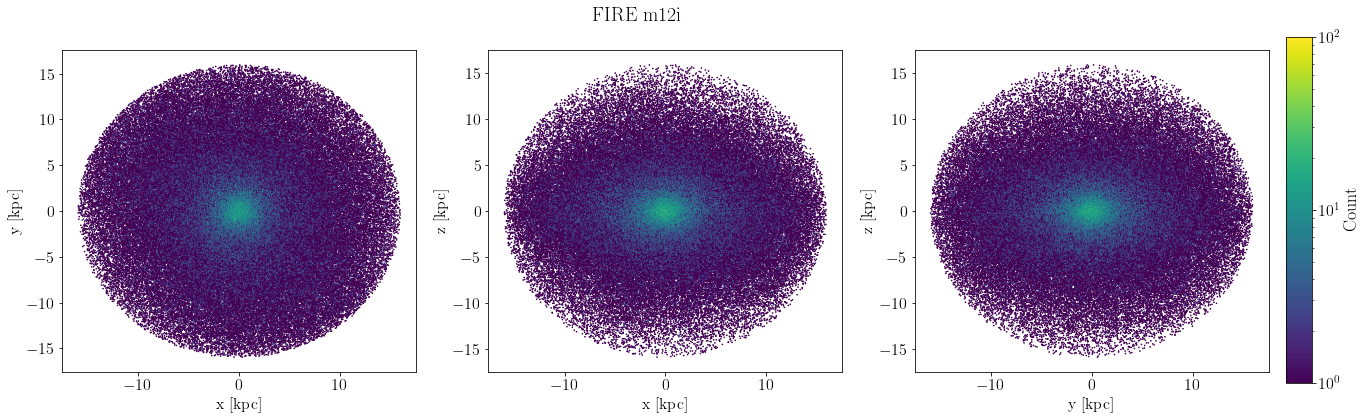

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
ax1, ax2, ax3 = axes.ravel()

gridsize = 500
norm = colors.LogNorm(vmin=1, vmax=1e2)

# Plot x-y plane
hb = ax1.hexbin(data['xstar'], data['ystar'], gridsize=gridsize, mincnt=1, norm=norm)
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')

# Plot x-z plane
ax2.hexbin(data['xstar'], data['zstar'], gridsize=gridsize, mincnt=1, norm=norm)
ax2.set_xlabel('x [kpc]')
ax2.set_ylabel('z [kpc]')

# Plot y-z plane
ax3.hexbin(data['ystar'], data['zstar'], gridsize=gridsize, mincnt=1, norm=norm)
ax3.set_xlabel('y [kpc]')
ax3.set_ylabel('z [kpc]')

# set colorbars
cbar_ax = fig.add_axes([1.0, 0.11, 0.02, 0.8])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.set_label(r'Count', fontsize=18)

fig.suptitle('FIRE m12i', fontsize=20)
fig.tight_layout()
fig.savefig('m12i_proj_table.png', dpi=300, bbox_inches='tight')